In [1]:
from feature_extension_funcs import title_name, define_groups, prices, embarked_filled, cabin_filled, age_filled_tit, age_groups

In [2]:
#from ipynb.fs.full.titanic_EDA_feature_eng import *

# STEP1 : Get Data & Libraries
##### Import libraries, load train data from Kaggle (already train/test splitted).

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn                 import metrics
from sklearn.dummy           import DummyClassifier
from sklearn.linear_model    import LogisticRegression
from sklearn.tree            import plot_tree, DecisionTreeClassifier
from sklearn.ensemble        import RandomForestClassifier
from sklearn.model_selection import GridSearchCV

from sklearn.model_selection import train_test_split, cross_validate, cross_val_score, KFold, ShuffleSplit
from sklearn.preprocessing   import MinMaxScaler, StandardScaler, OneHotEncoder
from sklearn.impute          import SimpleImputer
from impyute.imputation.cs   import mice

from sklearn.pipeline        import Pipeline, make_pipeline
from sklearn.compose         import ColumnTransformer
from sklearn.preprocessing   import FunctionTransformer

#from sklearn.metrics         import accuracy_score
#from sklearn.metrics         import ConfusionMatrixDisplay, confusion_matrix, roc_curve, auc

In [4]:
org_titanic_train = pd.read_csv('./data/train.csv')
org_titanic_test  = pd.read_csv('./data/test.csv')
# lowercase for feature names
org_titanic_train.columns = [i.lower() for i in org_titanic_train.columns]
org_titanic_test.columns  = [i.lower() for i in org_titanic_test.columns]

# STEP3: Train/Test Split

In [5]:
def extent_impute(inp_df):
    '''
    Extract new features and impute missing values. Look 'feature_extension_funcs.py' for functions.
    '''
    # Create features
    inp_df = prices(define_groups(title_name(inp_df)))
    # Impute by custom functions
    inp_df = age_groups(age_filled_tit((cabin_filled(embarked_filled(inp_df)))))
    
    return inp_df

inp_df = extent_impute(org_titanic_train)

In [6]:
X = inp_df.drop(columns=['survived']).copy()
y = inp_df['survived'].copy()

Xtrain, Xtest, Ytrain, Ytest = train_test_split(X, y, test_size=0.2, random_state=42)

In [7]:
print(Xtrain.shape, Ytrain.shape, Xtest.shape, Ytest.shape)
Xtrain.head(1)

(712, 20) (712,) (179, 20) (179,)


,passengerid,pclass,name,sex,age,sibsp,parch,ticket,fare,cabin,embarked,title,surname,famsize,grpsize,price,emb_fill,cabin_f_cat,age_filled_tit,age_group
331,332,1,"Partner, Mr. Austen",male,45.5,0,0,113043,28.5,C124,S,Mr.,Partner,1,1.0,28,S,1,45.5,3


# STEP 4: Feature Engineering

## Preprocessing: Pipelines & Hyperparameter Optimization

In [8]:
# Dictionaries for data and models
train_test_dict = {"train": [[Xtrain, Ytrain],'train'], "test": [[Xtest, Ytest],'test']}

model_dict = {
    "logr": [LogisticRegression(),'Logistic Reg.'],
    "dtc" : [DecisionTreeClassifier(), 'Decision Tree'] ,
    "rfc" : [RandomForestClassifier(), 'Random Forest']
}

#The Features!
features_dict= {'num_features' : ['age','famsize', 'price'],
                'cat_features' : ['pclass','sex','title','emb_fill','age_group', 'grpsize', 'famsize',  'cabin', 'surname'],
                'no_features'  : ['age_filled_tit', 'cabin_f_cat'],
                'drop_features': ['passengerid', 'name', 'sibsp', 'parch', 'ticket', 'fare', 'embarked']}

In [9]:
def run_model(xy_dict, param_grid, model_abrv, text=True, plt_data=True):
    '''
    Get scores for the given model.
    
    xy_dict    : Combined data train+test
    model_abrv : Abbreviation of models in the dict.
    sco_df     : Output data
    plt_data   : Plt confusion matrix and ROC
    text       : Information as print 
    
    '''
    sco_df=pd.DataFrame()
    score_temp_df = pd.DataFrame(columns=['Model_Name'])
    model = model_dict[model_abrv][0]
    
    # Organize train and test data to procees seperately from the dictionary
    for label, dfs in xy_dict.items():
        model_name = model_dict[model_abrv][1] + f'_{label}'
        x = dfs[0][0]
        y = dfs[0][1]
        
        #Build Pipelines
        built_pipeline = build_model_pipeline(model)
        built_pipeline = built_pipeline.fit(x,y)
        
        #Optimize Hyperparameters
        grid_pipeline = grid(built_pipeline, x, y, param_grid)
        
        #Scores: 
        score      = round(built_pipeline.score(x,y), 2)
        grid_score = round(grid_pipeline.best_estimator_.score(x,y), 2)
        y_pred     = grid_pipeline.best_estimator_.predict(x)
        
       
        accuracy      = round(metrics.accuracy_score (y, y_pred),2)
        precision     = round(metrics.precision_score(y, y_pred, pos_label=1),2)
        recall        = round(metrics.precision_score(y, y_pred, pos_label=1),2)
        f1            = round(metrics.f1_score       (y, y_pred),2)
        cv_score      = ss_cross_val(x, y, built_pipeline)
        
        # Print scores
        if text:
            print(f'=========== Results of {model_name}:')
            print(f'Score        {label}: {score:.4}')
            print(f'Grid Score   {label}: {grid_score:.4}')
            print(f'SS-Cross-Val {label}:')
            print(f"  CV-Score Val-Train: {cv_score['train_score'].mean():.4} \u00B1 {cv_score['train_score'].std():.4}")
            print(f"  CV-Score Val-Test : {cv_score['test_score'].mean():.4} \u00B1 {cv_score['test_score'].std():.4}")
            print(f'Accuracy     {label}: {accuracy:.4}')
            print(f'Precision    {label}: {precision:.4}')
            print(f'Recall       {label}: {recall:.4}')
            print(f'F1           {label}: {f1:.4}')

        
        #Plot confusion matrix and ROC
        if plt_data:
            plot_data(x, y, y_pred, built_pipeline, model_name)

        #For kaggle test set, output the predictions ax csv files
        if label == 'kaggle':
            kaggle_predict(grid_pipeline, model_name)
        
        
        #Save results from all models in same dataframe
        score_temp_df = pd.DataFrame([[ model_name, score,    grid_score,accuracy  , precision  ,recall   ,f1   , cv_score['train_score'].mean(), cv_score['train_score'].std(), cv_score['test_score'].mean(), cv_score['test_score'].std()]],
                             columns=['Model_Name','Score', 'Grid Score','Accuracy', 'Precision', 'Recall', 'F1', 'Cross-Val-train-mean',        'Cross-Val-train-std',          'Cross-Val-test-mean',         'Cross-Val-test-std'])
        sco_df = pd.concat([sco_df, score_temp_df], axis=0)
    
    return sco_df

In [10]:
from sklearn import set_config
set_config(display="diagram")

def build_model_pipeline(model):
    cat_pipe = make_pipeline(SimpleImputer(strategy='most_frequent'),
                             OneHotEncoder(handle_unknown='ignore')
                            )

    num_pipe = make_pipeline(SimpleImputer(strategy='median'),
                             MinMaxScaler()
                            )
    
    transformer = ColumnTransformer(
        transformers=[('num',  num_pipe, features_dict['num_features']),
                      ('cat',  cat_pipe, features_dict['cat_features'])],
                    remainder='drop')
    
    pipe = Pipeline([('feature_transformer', transformer), 
                     ('model', model)])
    
    pipe
    return pipe

In [11]:
def grid(built_pipeline, x, y , param_grid):
    '''
    Hyperparemeter optimization with given values
    '''
    
    gridsearch = GridSearchCV(built_pipeline, 
                          param_grid, 
                          cv=cv_ss,
                          scoring='accuracy',
                          n_jobs  = -1, 
                          verbose = 0)      
        
    gridsearch.fit(x,y)
    gridsearch.scorer_
    #print(gridsearch.get_params().keys())
    #print(gridsearch.best_score_)
    #pd.DataFrame(gridsearch.cv_results_).sort_values('rank_test_score')
    
    print(f'\nBest hyperparameters: {gridsearch.best_params_}')
    return gridsearch

In [12]:
cv_ss = ShuffleSplit(n_splits=5, test_size=0.2, random_state=42)

def ss_cross_val(x, y, built_model):
    '''
    Get Cross Validation score by shufflesplit.
    Output train and test validate scores as STR
    '''

    scores_ss = cross_validate(
    estimator = built_model, # model to evaluate
    X = x,
    y = y,
    cv = cv_ss,    # no. of cross-validation split
    scoring ='r2', # evaluation metric
    return_train_score=True
    )
    
    return scores_ss

In [13]:
def plot_data(x, y, y_pred, built_pipeline, model_name):
        '''
        Plot confusion matrix and RoC Curve
    
        '''  
        metrics.ConfusionMatrixDisplay.from_predictions(y, y_pred, normalize=None)
        plt.title(f"{model_name} - Confusion Matrix")
        roc_auc = metrics.RocCurveDisplay.from_estimator(built_pipeline, X=x, y=y)
        plt.title(f"{model_name} - ROC")

In [14]:
#This functions train models on whole Kaggle_train data and estimates with best parameters Kaggle_test data and save as csv
def kaggle_predict(grid_pipeline, model_name):
    y_pred_kaggle_test = grid_pipeline.best_estimator_.predict(X_kag_test)
    kag_df = pd.concat([passenger_list, pd.Series(y_pred_kaggle_test, name='Survived')], axis=1, join='outer')
    kag_df.to_csv(f'\kaggle_pred\ {model_name}.csv', header=True, index=False)

# STEP5: Modeling

In [15]:
all_scores_df  = pd.DataFrame()

## Feature Set 1:

In [16]:
#Model with original features
features_dict1 = {'num_features' : ['age', 'fare', 'sibsp', 'parch'],
                'cat_features' : ['pclass','sex', 'embarked', 'cabin'],
                'drop_features': ['passengerid', 'name', 'ticket']}
features_dict  = features_dict1


Best hyperparameters: {'model__max_iter': 100, 'model__random_state': 30}
=========== Results of Logistic Reg._train:
Score        train: 0.84
Grid Score   train: 0.84
SS-Cross-Val train:
  CV-Score Val-Train: 0.333 ± 0.02523
  CV-Score Val-Test : 0.09443 ± 0.1075
Accuracy     train: 0.84
Precision    train: 0.81
Recall       train: 0.81
F1           train: 0.78

Best hyperparameters: {'model__max_iter': 100, 'model__random_state': 30}
=========== Results of Logistic Reg._test:
Score        test: 0.84
Grid Score   test: 0.84
SS-Cross-Val test:
  CV-Score Val-Train: 0.3535 ± 0.07206
  CV-Score Val-Test : 0.08517 ± 0.286
Accuracy     test: 0.84
Precision    test: 0.8
Recall       test: 0.8
F1           test: 0.81

Best hyperparameters: {'model__max_depth': 7, 'model__random_state': 42}
=========== Results of Decision Tree_train:
Score        train: 0.98
Grid Score   train: 0.89
SS-Cross-Val train:
  CV-Score Val-Train: 0.9478 ± 0.008215
  CV-Score Val-Test : 0.04116 ± 0.0922
Accuracy   

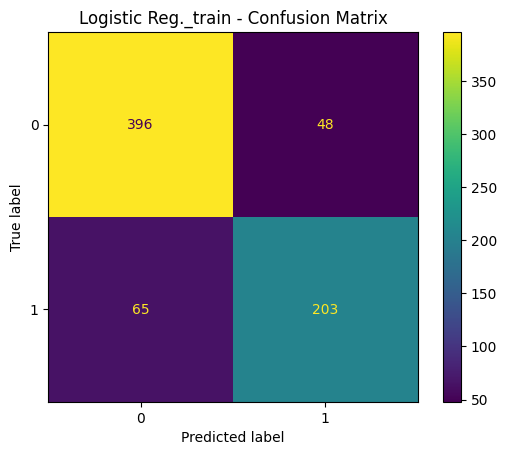

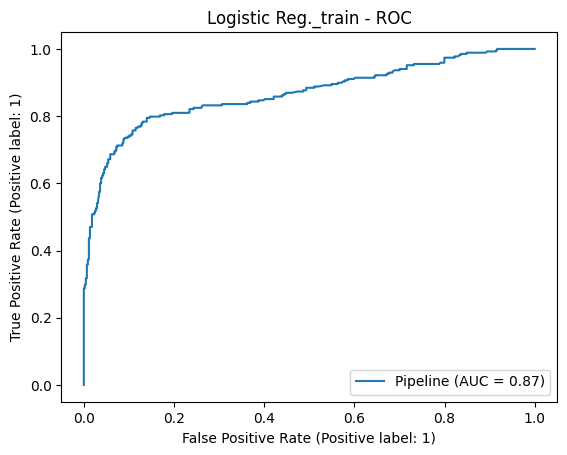

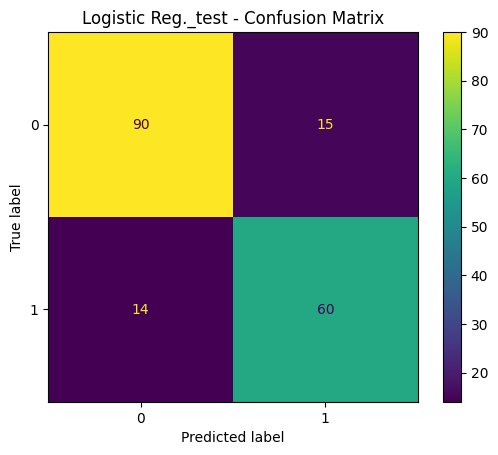

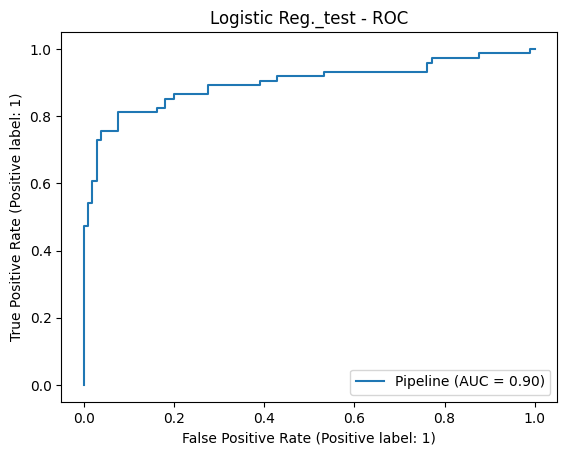

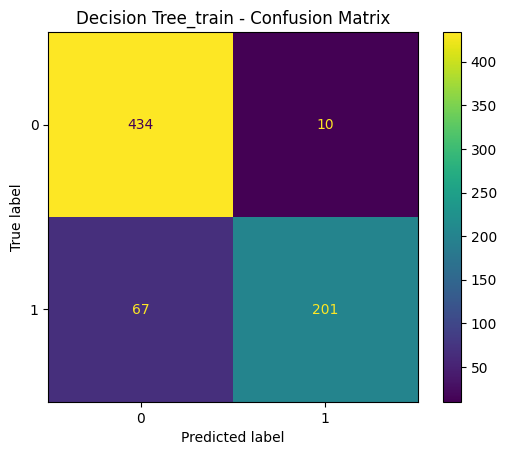

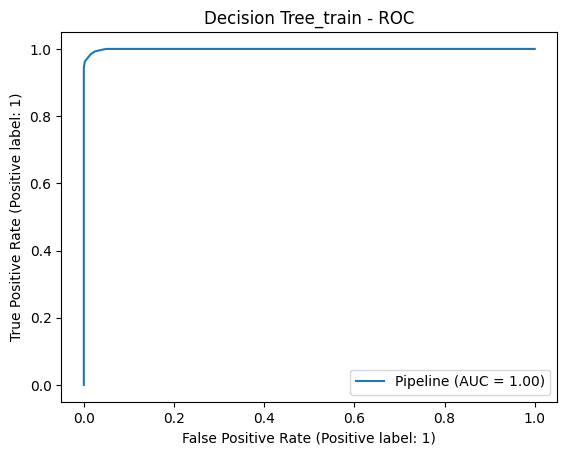

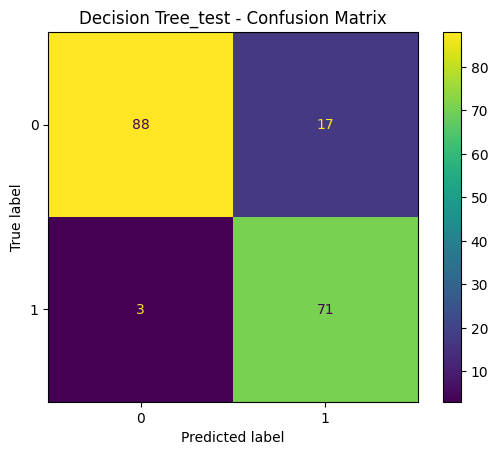

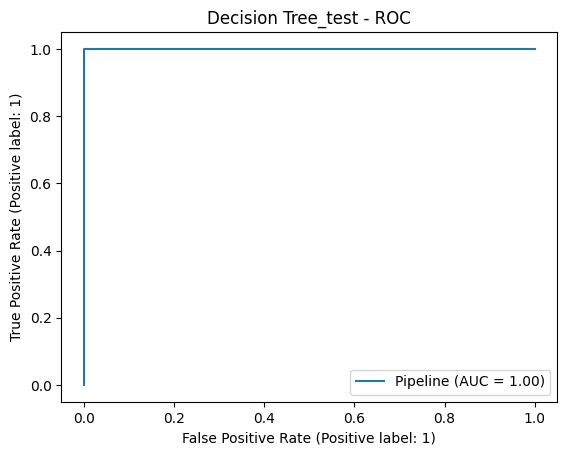

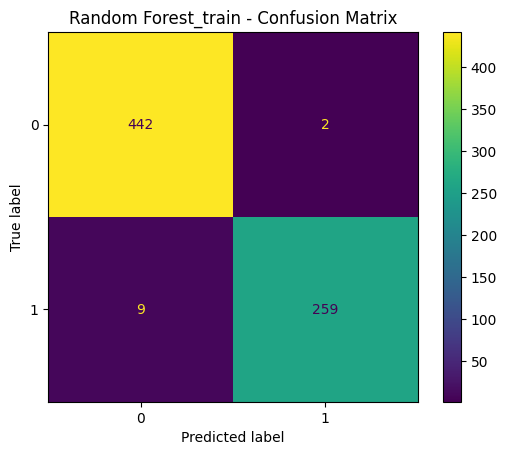

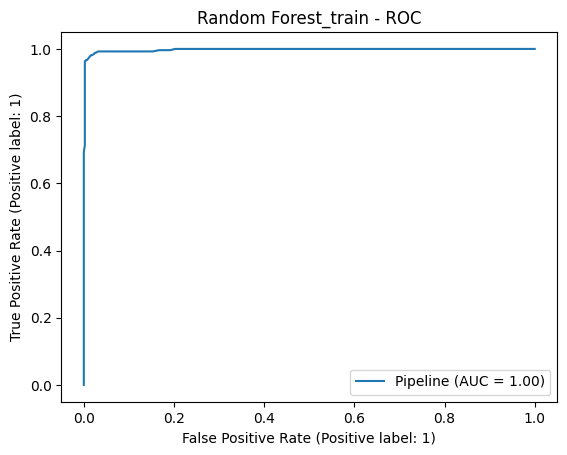

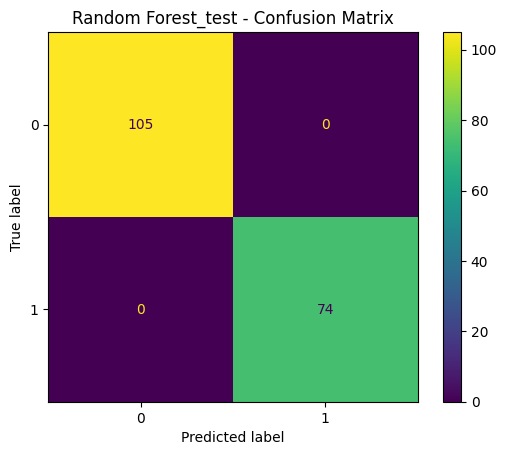

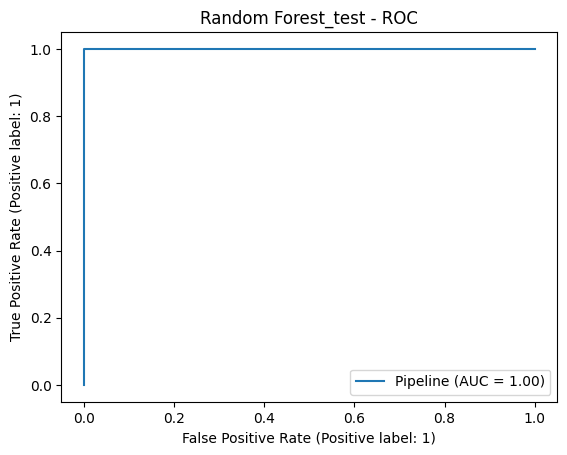

In [17]:
param_grid    = {'model__max_iter'     : [100, 150, 200],
                 'model__random_state' : [30, 42, 100]
}
all_scores_df = pd.concat([all_scores_df, run_model(train_test_dict, param_grid, 'logr', plt_data=True)], axis=0)

param_grid    = {'model__max_depth': [5, 6, 7],
                'model__random_state' : [22, 42, 100]
                }
all_scores_df = pd.concat([all_scores_df, run_model(train_test_dict, param_grid, 'dtc', plt_data=True)], axis=0)

param_grid    = {'model__max_depth': [200], 'model__n_estimators': [150 , 200, 250]}
all_scores_df = pd.concat([all_scores_df, run_model(train_test_dict, param_grid, 'rfc', plt_data=True)], axis=0)

## Feature Set 2:

In [18]:
features_dict2 = {'num_features' : ['age','famsize', 'price'],
                'cat_features' : ['pclass','sex','title','emb_fill','age_group', 'grpsize', 'famsize',  'cabin', 'surname'],}

features_dict  = features_dict2


Best hyperparameters: {'model__max_iter': 100, 'model__random_state': 15}
=========== Results of Logistic Reg._train:
Score        train: 0.9
Grid Score   train: 0.9
SS-Cross-Val train:
  CV-Score Val-Train: 0.5912 ± 0.02276
  CV-Score Val-Test : 0.2542 ± 0.06782
Accuracy     train: 0.9
Precision    train: 0.9
Recall       train: 0.9
F1           train: 0.86

Best hyperparameters: {'model__max_iter': 100, 'model__random_state': 15}
=========== Results of Logistic Reg._test:
Score        test: 0.92
Grid Score   test: 0.92
SS-Cross-Val test:
  CV-Score Val-Train: 0.7027 ± 0.03731
  CV-Score Val-Test : -0.02143 ± 0.1854
Accuracy     test: 0.92
Precision    test: 0.9
Recall       test: 0.9
F1           test: 0.9

Best hyperparameters: {'model__max_depth': 20, 'model__random_state': 100}
=========== Results of Decision Tree_train:
Score        train: 1.0
Grid Score   train: 0.97
SS-Cross-Val train:
  CV-Score Val-Train: 0.997 ± 0.003666
  CV-Score Val-Test : 0.1752 ± 0.1339
Accuracy     tr

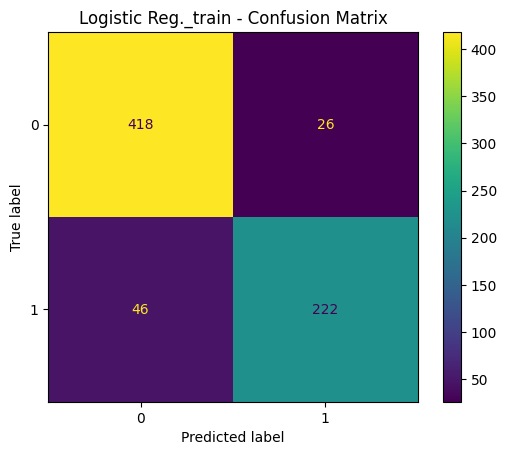

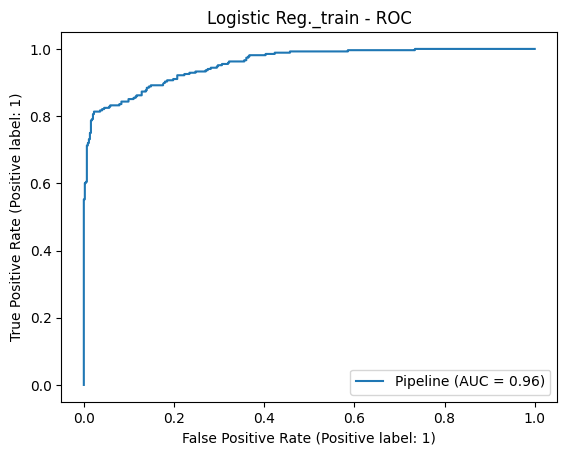

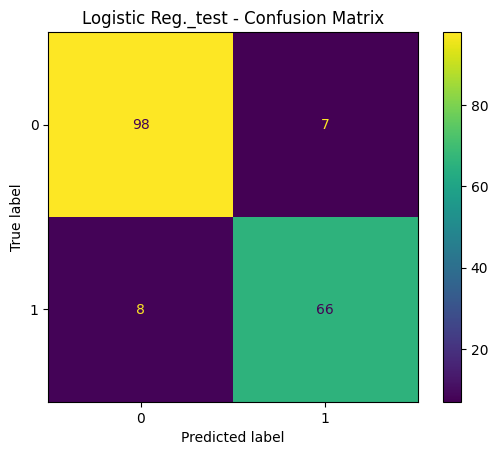

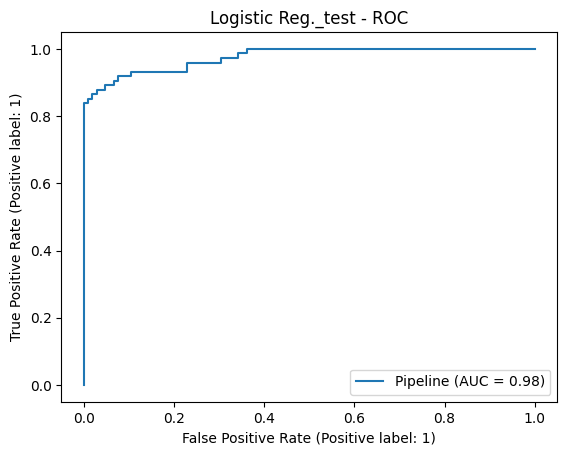

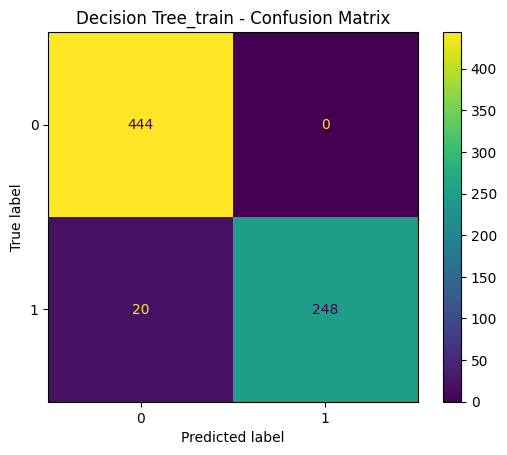

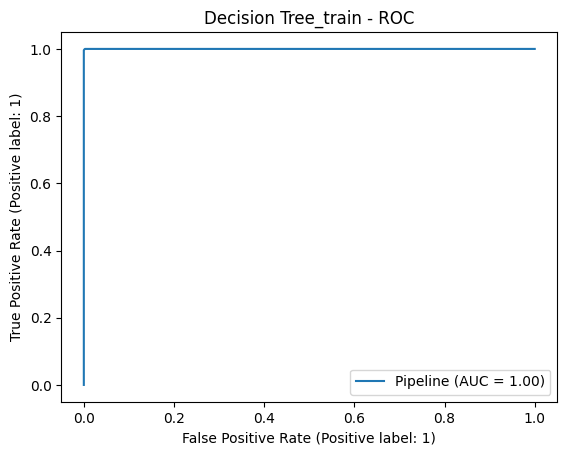

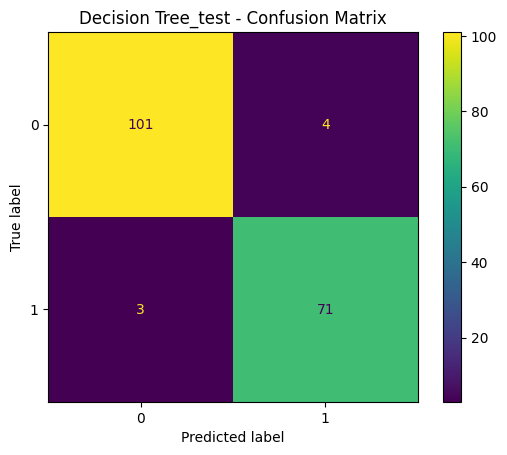

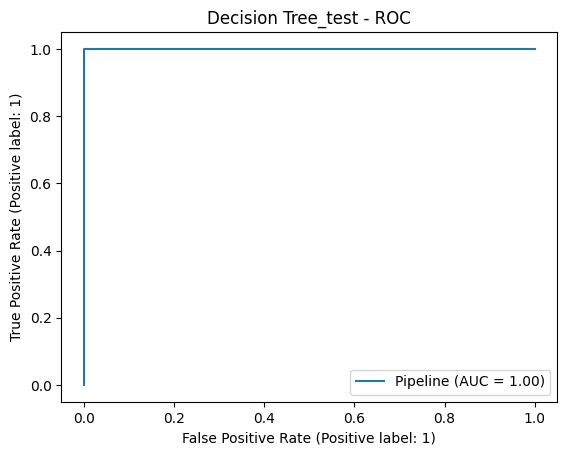

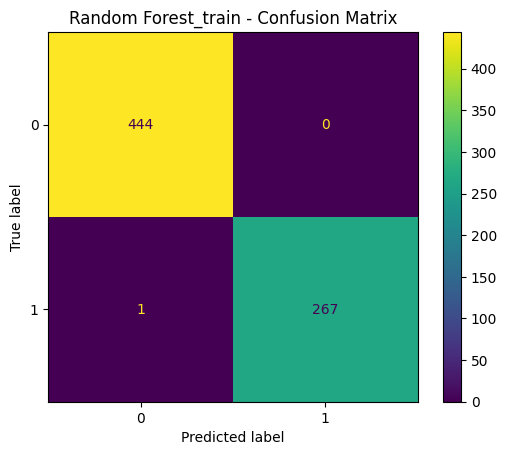

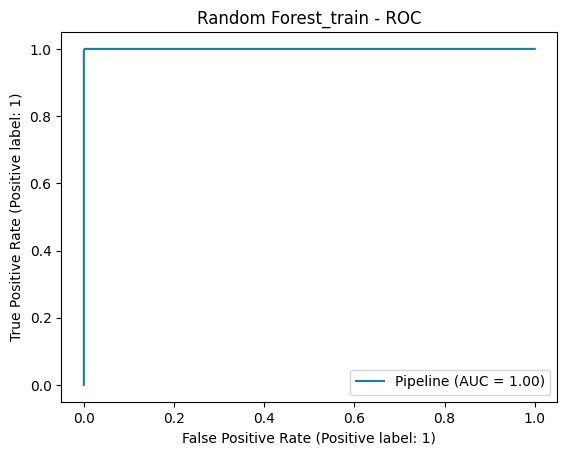

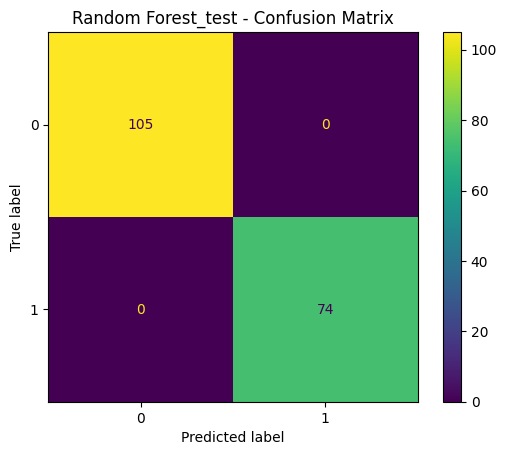

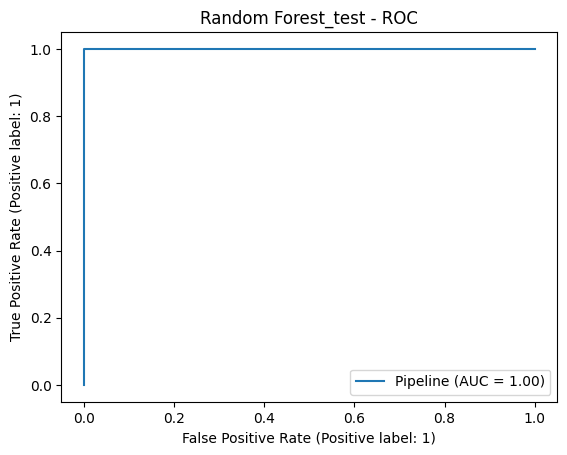

In [19]:
param_grid    = {'model__max_iter'     : [100, 150, 200],
                 'model__random_state' : [15, 30, 42]
}
all_scores_df = pd.concat([all_scores_df, run_model(train_test_dict, param_grid, 'logr', plt_data=True)], axis=0)

param_grid    = {'model__max_depth': [2, 5, 6, 20],
                'model__random_state' : [22, 42, 100]
                }
all_scores_df = pd.concat([all_scores_df, run_model(train_test_dict, param_grid, 'dtc', plt_data=True)], axis=0)

param_grid    = {'model__max_depth': [200], 'model__n_estimators': [150 , 200, 250]}
all_scores_df = pd.concat([all_scores_df, run_model(train_test_dict, param_grid, 'rfc', plt_data=True)], axis=0)

## Feature Set 3:

In [20]:
features_dict3 = {'num_features' : ['age_filled_tit', 'price'],
                'cat_features' : ['grpsize', 'pclass','sex','title','emb_fill', 'cabin']}

features_dict  = features_dict3


Best hyperparameters: {'model__max_iter': 100, 'model__random_state': 15}
=========== Results of Logistic Reg._train:
Score        train: 0.87
Grid Score   train: 0.87
SS-Cross-Val train:
  CV-Score Val-Train: 0.4196 ± 0.01986
  CV-Score Val-Test : 0.2657 ± 0.08528
Accuracy     train: 0.87
Precision    train: 0.83
Recall       train: 0.83
F1           train: 0.82

Best hyperparameters: {'model__max_iter': 100, 'model__random_state': 15}
=========== Results of Logistic Reg._test:
Score        test: 0.88
Grid Score   test: 0.88
SS-Cross-Val test:
  CV-Score Val-Train: 0.5139 ± 0.05865
  CV-Score Val-Test : 0.04889 ± 0.2086
Accuracy     test: 0.88
Precision    test: 0.86
Recall       test: 0.86
F1           test: 0.86

Best hyperparameters: {'model__max_depth': 2, 'model__random_state': 42}
=========== Results of Decision Tree_train:
Score        train: 0.97
Grid Score   train: 0.8
SS-Cross-Val train:
  CV-Score Val-Train: 0.8791 ± 0.007802
  CV-Score Val-Test : 0.03281 ± 0.2065
Accuracy

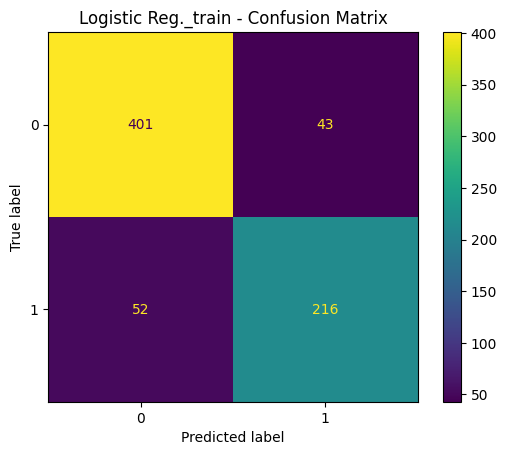

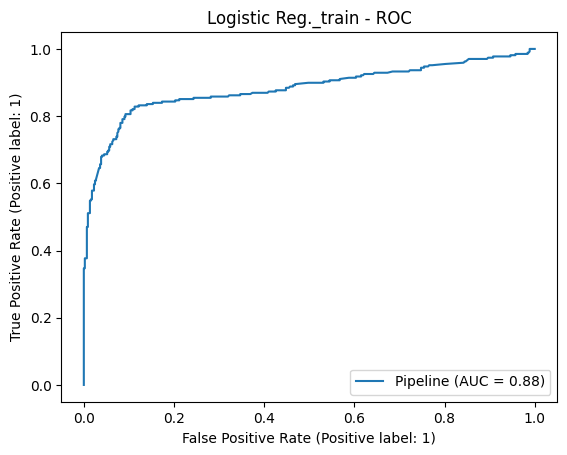

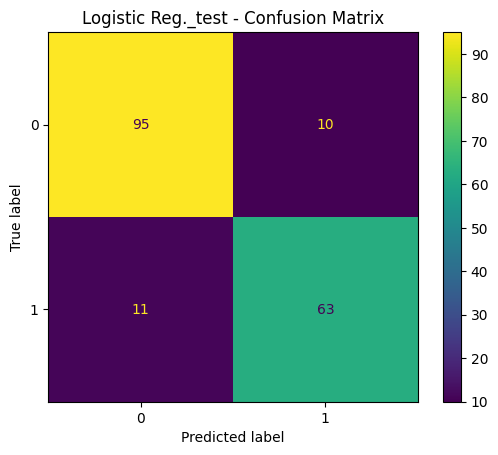

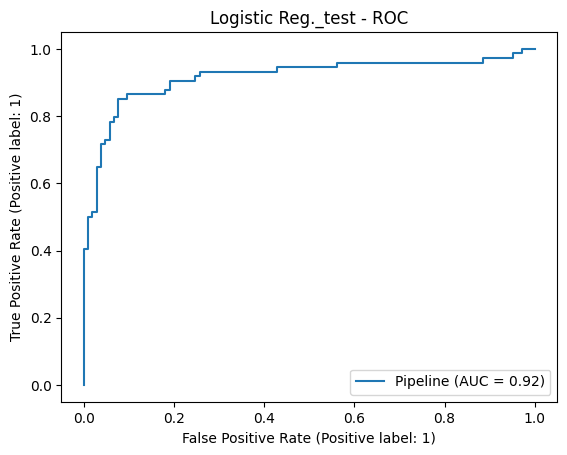

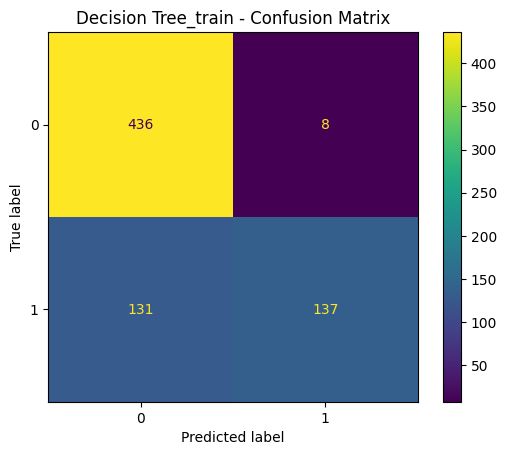

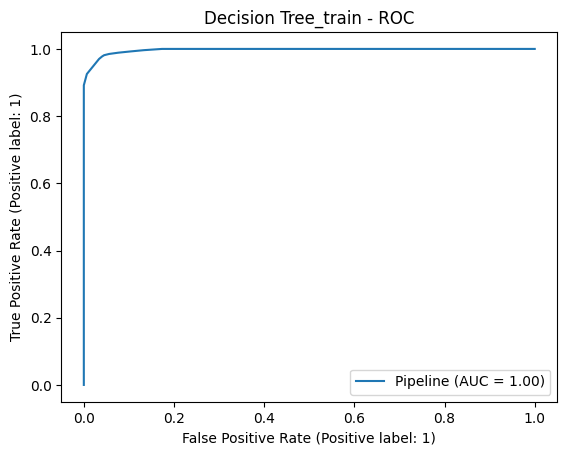

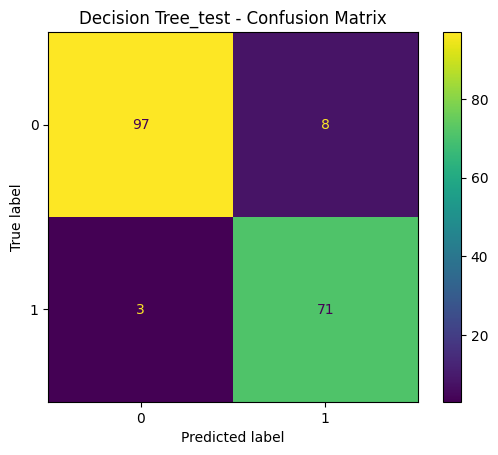

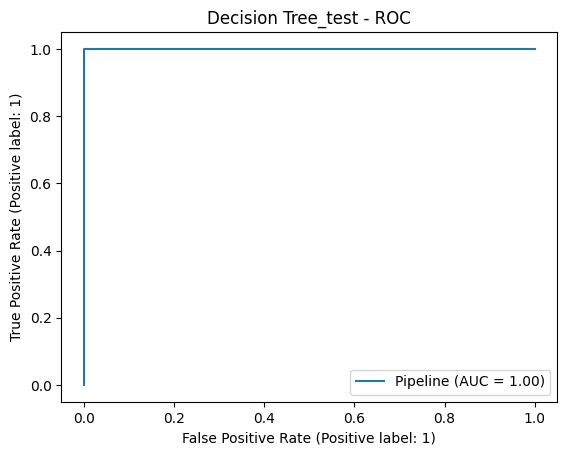

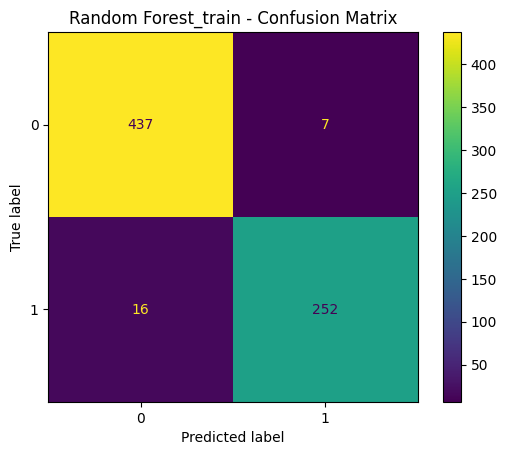

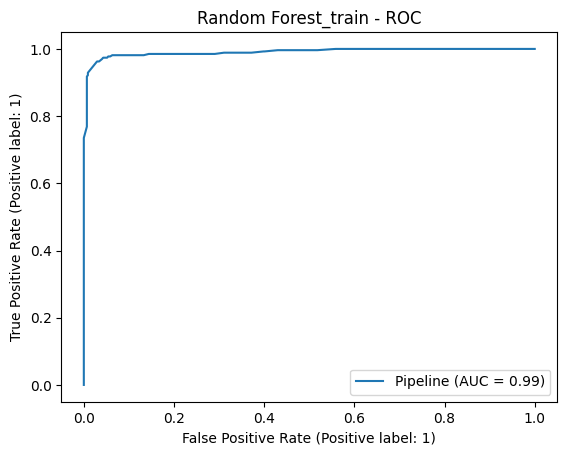

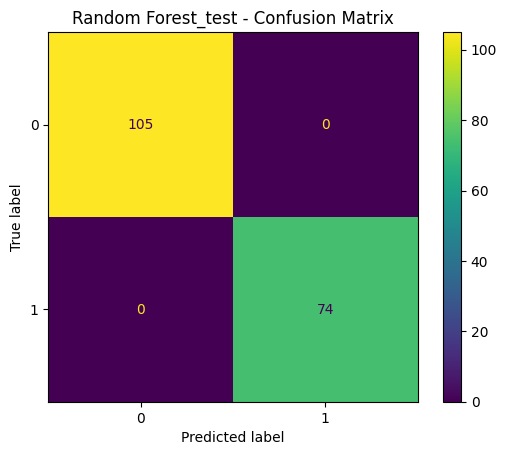

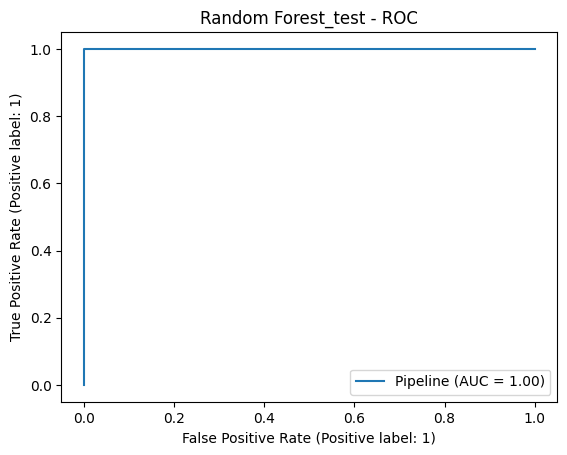

In [21]:
param_grid    = {'model__max_iter'     : [100, 150],
                 'model__random_state' : [15, 30, 42]
}
all_scores_df = pd.concat([all_scores_df, run_model(train_test_dict, param_grid, 'logr', plt_data=True)], axis=0)

param_grid    = {'model__max_depth': [2, 5, 8],
                'model__random_state' : [42, 100, 142]
                }
all_scores_df = pd.concat([all_scores_df, run_model(train_test_dict, param_grid, 'dtc', plt_data=True)], axis=0)

param_grid    = {'model__max_depth': [200], 'model__n_estimators': [150 , 200, 250]}
all_scores_df = pd.concat([all_scores_df, run_model(train_test_dict, param_grid, 'rfc', plt_data=True)], axis=0)

## Models Summary

In [22]:
all_scores_df

,Model_Name,Score,Grid Score,Accuracy,Precision,Recall,F1,Cross-Val-train-mean,Cross-Val-train-std,Cross-Val-test-mean,Cross-Val-test-std
0,Logistic Reg._train,0.84,0.84,0.84,0.81,0.81,0.78,0.332959,0.025225,0.094430,0.107457
0,Logistic Reg._test,0.84,0.84,0.84,0.80,0.80,0.81,0.353459,0.072055,0.085174,0.285965
0,Decision Tree_train,0.98,0.89,0.89,0.95,0.95,0.84,0.947762,0.008215,0.041156,0.092202
0,Decision Tree_test,1.00,0.89,0.89,0.81,0.81,0.88,1.000000,0.000000,-0.231608,0.364869
0,Random Forest_train,0.98,0.98,0.98,0.99,0.99,0.98,0.947762,0.008215,0.126076,0.089576
0,Random Forest_test,1.00,1.00,1.00,1.00,1.00,1.00,1.000000,0.000000,-0.085257,0.276567
0,Logistic Reg._train,0.90,0.90,0.90,0.90,0.90,0.86,0.591156,0.022763,0.254222,0.067823
0,Logistic Reg._test,0.92,0.92,0.92,0.90,0.90,0.90,0.702709,0.037310,-0.021426,0.185436
0,Decision Tree_train,1.00,0.97,0.97,1.00,1.00,0.96,0.997007,0.003666,0.175220,0.133888
0,Decision Tree_test,1.00,0.96,0.96,0.95,0.95,0.95,1.000000,0.000000,0.271612,0.089762


Hyperparemeters



# STEP6: Calculate Test Score (Submit Predictions to Kaggle)

In [23]:
all_kaggle_score = pd.DataFrame()

In [24]:
# Create & Impute features
inp_df2      = extent_impute(org_titanic_train)
kag_test_df  = org_titanic_test.copy()
kag_test_df.fillna(value=7, inplace=True) #Missing value from pclass3, median is 7 for pclass3
kag_test_df  = extent_impute(kag_test_df)

In [25]:
passenger_list      = kag_test_df['passengerid']
passenger_list.name = 'PassengerId'

X_kag_test          = kag_test_df

X_kag               = inp_df2.drop(columns=['survived'])
Y_kag               = inp_df2['survived']
kaggle_train_dict   = {"kaggle": [[X_kag, Y_kag],'kaggle']}

In [26]:
features_dict  = features_dict1
param_grid    = {'model__max_iter'     : [100, 150],
                 'model__random_state' : [15, 30, 42]
}
all_kaggle_score = pd.concat([all_scores_df, run_model(kaggle_train_dict, param_grid, 'logr', plt_data=False)], axis=0)


Best hyperparameters: {'model__max_iter': 100, 'model__random_state': 15}
=========== Results of Logistic Reg._kaggle:
Score        kaggle: 0.83
Grid Score   kaggle: 0.83
SS-Cross-Val kaggle:
  CV-Score Val-Train: 0.2988 ± 0.01734
  CV-Score Val-Test : 0.2055 ± 0.06172
Accuracy     kaggle: 0.83
Precision    kaggle: 0.8
Recall       kaggle: 0.8
F1           kaggle: 0.78


In [27]:
features_dict  = features_dict2
param_grid    = {'model__max_iter'     : [100, 150],
                 'model__random_state' : [15, 30, 42]
}
all_kaggle_score = pd.concat([all_scores_df, run_model(kaggle_train_dict, param_grid, 'logr', plt_data=False)], axis=0)


Best hyperparameters: {'model__max_iter': 100, 'model__random_state': 15}
=========== Results of Logistic Reg._kaggle:
Score        kaggle: 0.9
Grid Score   kaggle: 0.9
SS-Cross-Val kaggle:
  CV-Score Val-Train: 0.5687 ± 0.01902
  CV-Score Val-Test : 0.3804 ± 0.0865
Accuracy     kaggle: 0.9
Precision    kaggle: 0.89
Recall       kaggle: 0.89
F1           kaggle: 0.87


In [28]:
features_dict  = features_dict3
param_grid    = {'model__max_iter'     : [100, 150],
                 'model__random_state' : [15, 30, 42]
}
all_kaggle_score = pd.concat([all_scores_df, run_model(kaggle_train_dict, param_grid, 'logr', plt_data=False)], axis=0)


Best hyperparameters: {'model__max_iter': 100, 'model__random_state': 15}
=========== Results of Logistic Reg._kaggle:
Score        kaggle: 0.87
Grid Score   kaggle: 0.87
SS-Cross-Val kaggle:
  CV-Score Val-Train: 0.4234 ± 0.01366
  CV-Score Val-Test : 0.3383 ± 0.1116
Accuracy     kaggle: 0.87
Precision    kaggle: 0.84
Recall       kaggle: 0.84
F1           kaggle: 0.82
